In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import math
import itertools

# Physical constants and simulation parameters
epsilon = 1.0      # LJ energy parameter (reduced units)
sigma = 1.0        # LJ length parameter (reduced units)
mass = 1.0         # Particle mass (reduced units)
kB = 1.0           # Boltzmann constant (reduced units)

# Simulation parameters
N_particles = 108   # Number of particles
rho = 0.8442       # Density (reduced units)
target_total_energy_per_particle = -2.1626  # Target total energy per particle
dt = 0.001         # Time step (reduced units)
n_steps = 600000    # Total simulation steps
cutoff = 2.5 * sigma  # LJ potential cutoff radius

# Calculate box dimensions from density
box_volume = N_particles / rho
L = box_volume**(1/3)  # Box length (cubic box)

# Calculate lattice spacing
spacing = L / math.ceil(N_particles ** (1/3))

print(f"System setup:")
print(f"Number of particles: {N_particles}")
print(f"Density: {rho}")
print(f"Box volume: {box_volume:.3f}")
print(f"Box length: {L:.3f}")
print(f"Lattice spacing: {spacing:.3f}")
print(f"Time step: {dt}")
print(f"Target total energy per particle: {target_total_energy_per_particle}")

System setup:
Number of particles: 108
Density: 0.8442
Box volume: 127.932
Box length: 5.039
Lattice spacing: 1.008
Time step: 0.001
Target total energy per particle: -2.1626


In [3]:
def calculate_pe_of_lattice(positions):
    """Calculate PE of the initial simple cubic lattice"""
    energy = 0.0
    for i in range(N_particles):
        for j in range(i + 1, N_particles):
            # Distance with periodic boundary conditions
            dr = np.array(positions[i]) - np.array(positions[j])
            dr = dr - L * np.round(dr / L)
            r = np.linalg.norm(dr)
            
            # LJ potential with truncation and shift at r_cut = 2.5
            if r <= 2.5:
                r6 = (1.0/r)**6
                r12 = r6 * r6
                u_lj = 4.0 * (r12 - r6)
                # Shift correction
                u_cut = 4.0 * ((1.0/2.5)**12 - (1.0/2.5)**6)
                energy += u_lj - u_cut
    return energy

# Create lattice positions using linspace and itertools
x = np.linspace(-L / 2, L / 2, math.ceil(N_particles ** (1/3)), endpoint=False)
position = list(itertools.product(x, repeat=3))

# Convert to numpy array and take only the first N_particles
positions = np.array(position[:N_particles])

# Calculate initial lattice potential energy
lattice_pe = calculate_pe_of_lattice(positions)
lattice_pe_per_particle = lattice_pe / N_particles

print(f"Lattice setup:")
print(f"Number of lattice points per dimension: {len(x)}")
print(f"Total lattice points available: {len(position)}")
print(f"Using first {N_particles} positions")

print(f"Lattice created with {len(positions)} particles")
print(f"Position range: X=[{positions[:, 0].min():.3f}, {positions[:, 0].max():.3f}]")
print(f"                Y=[{positions[:, 1].min():.3f}, {positions[:, 1].max():.3f}]")
print(f"                Z=[{positions[:, 2].min():.3f}, {positions[:, 2].max():.3f}]")
print(f"Lattice potential energy: {lattice_pe:.6f}")
print(f"Lattice PE per particle: {lattice_pe_per_particle:.6f}")

Lattice setup:
Number of lattice points per dimension: 5
Total lattice points available: 125
Using first 108 positions
Lattice created with 108 particles
Position range: X=[-2.519, 1.512]
                Y=[-2.519, 1.512]
                Z=[-2.519, 1.512]
Lattice potential energy: -351.097098
Lattice PE per particle: -3.250899


In [4]:
def maxwell_boltzmann_velocities(N, T, mass):
    """Generate random velocities from Maxwell-Boltzmann distribution."""
    # Standard deviation for each velocity component
    sigma_v = np.sqrt(kB * T / mass)
    
    # Generate random velocities
    velocities = np.random.normal(0, sigma_v, (N, 3))
    
    # Remove centre-of-mass motion
    cm_velocity = np.mean(velocities, axis=0)
    velocities -= cm_velocity
    
    # Scale to exact target temperature
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    target_kinetic = 0.5 * 3 * N * kB * T  # 3N/2 * kB * T
    scale_factor = np.sqrt(target_kinetic / kinetic_energy)
    velocities *= scale_factor
    
    return velocities

def lennard_jones_force(positions, L, epsilon, sigma, cutoff):
    """Calculate Lennard-Jones forces between all particles with truncation and shift."""
    N = len(positions)
    forces = np.zeros_like(positions)
    potential_energy = 0.0
    
    # Shift correction at cutoff
    u_cut = 4.0 * ((1.0/cutoff)**12 - (1.0/cutoff)**6)
    
    for i in range(N):
        for j in range(i + 1, N):
            # Calculate distance vector
            dr = positions[j] - positions[i]
            
            # Apply minimum image convention (periodic boundaries)
            dr = dr - L * np.round(dr / L)
            
            # Distance magnitude
            r = np.linalg.norm(dr)
            
            if r < cutoff and r > 0:
                # LJ potential and force calculation
                r6 = (1.0/r)**6
                r12 = r6 * r6
                
                # Potential energy with shift
                u_lj = 4.0 * (r12 - r6)
                potential_energy += u_lj - u_cut
                
                # Force magnitude
                force_magnitude = 24.0 / r * (2 * r12 - r6)
                
                # Force vector
                force_vector = force_magnitude * dr / r
                
                # Newton's third law
                forces[i] += force_vector
                forces[j] -= force_vector
    
    return forces, potential_energy

# Calculate required temperature to achieve target total energy
target_ke_per_particle = target_total_energy_per_particle - lattice_pe_per_particle
temperature = (2.0 / 3.0) * target_ke_per_particle / kB

print(f"Energy analysis:")
print(f"Target total energy per particle: {target_total_energy_per_particle:.6f}")
print(f"Lattice PE per particle: {lattice_pe_per_particle:.6f}")
print(f"Required KE per particle: {target_ke_per_particle:.6f}")
print(f"Required temperature: {temperature:.6f}")

# Initialise velocities
velocities = maxwell_boltzmann_velocities(N_particles, temperature, mass)

# Calculate initial forces and potential energy
forces, potential_energy = lennard_jones_force(positions, L, epsilon, sigma, cutoff)

# Calculate initial kinetic energy
kinetic_energy = 0.5 * mass * np.sum(velocities**2)
total_energy = kinetic_energy + potential_energy

# Calculate energies per particle
ke_per_particle = kinetic_energy / N_particles
pe_per_particle = potential_energy / N_particles
total_energy_per_particle = total_energy / N_particles

# Calculate instantaneous temperature
instantaneous_temp = 2 * kinetic_energy / (3 * N_particles * kB)

print(f"\nInitial system state:")
print(f"Kinetic energy: {kinetic_energy:.6f} ({ke_per_particle:.6f} per particle)")
print(f"Potential energy: {potential_energy:.6f} ({pe_per_particle:.6f} per particle)")
print(f"Total energy: {total_energy:.6f} ({total_energy_per_particle:.6f} per particle)")
print(f"Instantaneous temperature: {instantaneous_temp:.6f}")
print(f"Target temperature: {temperature:.6f}")
print(f"Maximum force magnitude: {np.max(np.linalg.norm(forces, axis=1)):.6f}")

# Verify zero total momentum
total_momentum = mass * np.sum(velocities, axis=0)
print(f"Total momentum: [{total_momentum[0]:.2e}, {total_momentum[1]:.2e}, {total_momentum[2]:.2e}]")

Energy analysis:
Target total energy per particle: -2.162600
Lattice PE per particle: -3.250899
Required KE per particle: 1.088299
Required temperature: 0.725533

Initial system state:
Kinetic energy: 117.536298 (1.088299 per particle)
Potential energy: -351.097098 (-3.250899 per particle)
Total energy: -233.560800 (-2.162600 per particle)
Instantaneous temperature: 0.725533
Target temperature: 0.725533
Maximum force magnitude: 27.576331
Total momentum: [2.89e-15, -2.50e-15, -3.11e-15]


In [5]:
def apply_periodic_boundaries(positions, L):
    """Apply periodic boundary conditions to positions."""
    return positions - L * np.round(positions / L)

def velocity_verlet_step(positions, velocities, forces, dt, L, mass):
    """Perform one step of velocity-Verlet integration."""
    
    # Step 1: Update positions
    # r(t+dt) = r(t) + v(t)*dt + 0.5*a(t)*dt^2
    accelerations = forces / mass
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    
    # Apply periodic boundary conditions
    new_positions = apply_periodic_boundaries(new_positions, L)
    
    # Step 2: Calculate forces at new positions
    new_forces, potential_energy = lennard_jones_force(new_positions, L, epsilon, sigma, cutoff)
    
    # Step 3: Update velocities
    # v(t+dt) = v(t) + 0.5*[a(t) + a(t+dt)]*dt
    new_accelerations = new_forces / mass
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
    
    return new_positions, new_velocities, new_forces, potential_energy

def calculate_system_properties(positions, velocities, potential_energy, mass, N):
    """Calculate kinetic energy, total energy, and temperature."""
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    total_energy = kinetic_energy + potential_energy
    temperature = 2 * kinetic_energy / (3 * N * kB)
    
    return kinetic_energy, total_energy, temperature

# Test the integration step
print("Testing velocity-Verlet integration:")
test_pos, test_vel, test_forces, test_pe = velocity_verlet_step(
    positions.copy(), velocities.copy(), forces, dt, L, mass)

test_ke, test_total, test_temp = calculate_system_properties(
    test_pos, test_vel, test_pe, mass, N_particles)

print(f"After one integration step:")
print(f"Kinetic energy: {test_ke:.6f}")
print(f"Potential energy: {test_pe:.6f}")
print(f"Total energy: {test_total:.6f}")
print(f"Temperature: {test_temp:.6f}")
print(f"Energy conservation check: ΔE = {(test_total - total_energy):.2e}")

Testing velocity-Verlet integration:
After one integration step:
Kinetic energy: 117.614968
Potential energy: -351.018433
Total energy: -233.403465
Temperature: 0.726018
Energy conservation check: ΔE = 1.57e-01


Testing optimised force calculation speed...
Fast force calculation took: 0.0104 seconds

Running optimised simulation...
Starting optimised MD simulation:
Total steps: 600000
Time step: 0.001
Save frequency: every 100 steps
Initial total energy: -233.560800
Initial temperature: 0.725533

Progress:   5.0% | Step:  30000 | Energy: -233.5528 | Temp:  1.652
Progress:  10.0% | Step:  60000 | Energy: -233.5585 | Temp:  1.587
Progress:  15.0% | Step:  90000 | Energy: -233.5592 | Temp:  1.393
Progress:  20.0% | Step: 120000 | Energy: -233.5554 | Temp:  1.602
Progress:  25.0% | Step: 150000 | Energy: -233.5669 | Temp:  1.437
Progress:  30.0% | Step: 180000 | Energy: -233.5734 | Temp:  1.544
Progress:  35.0% | Step: 210000 | Energy: -233.5723 | Temp:  1.517
Progress:  40.0% | Step: 240000 | Energy: -233.5784 | Temp:  1.603
Progress:  45.0% | Step: 270000 | Energy: -233.5947 | Temp:  1.599
Progress:  50.0% | Step: 300000 | Energy: -233.5843 | Temp:  1.559
Progress:  55.0% | Step: 330000 | Energy

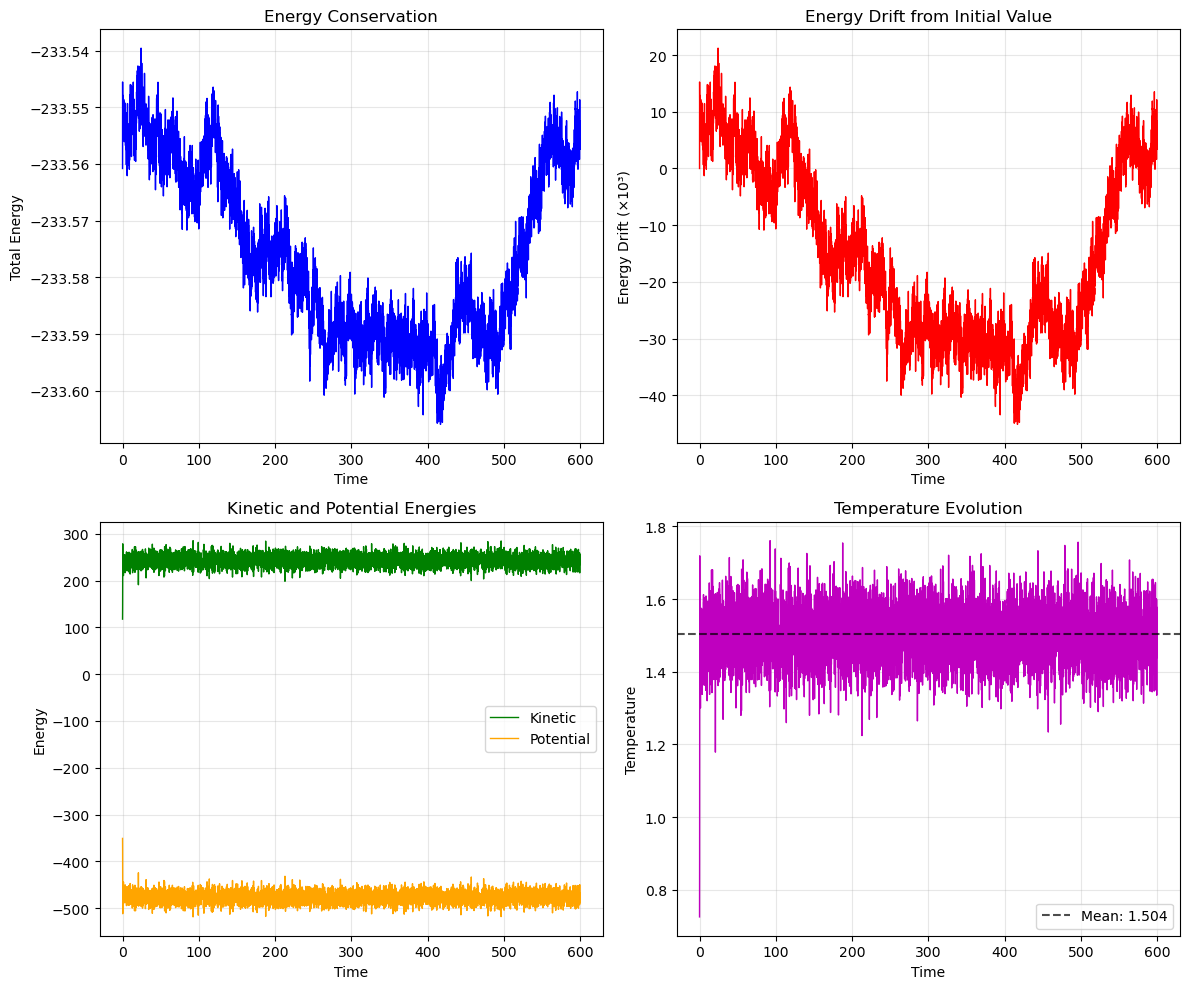

Starting optimised MD simulation:
Total steps: 600000
Time step: 0.001
Save frequency: every 50 steps
Initial total energy: -233.560800
Initial temperature: 0.725533

Progress:   5.0% | Step:  30000 | Energy: -233.5528 | Temp:  1.652
Progress:  10.0% | Step:  60000 | Energy: -233.5585 | Temp:  1.587
Progress:  15.0% | Step:  90000 | Energy: -233.5592 | Temp:  1.393
Progress:  20.0% | Step: 120000 | Energy: -233.5554 | Temp:  1.602
Progress:  25.0% | Step: 150000 | Energy: -233.5669 | Temp:  1.437
Progress:  30.0% | Step: 180000 | Energy: -233.5734 | Temp:  1.544
Progress:  35.0% | Step: 210000 | Energy: -233.5723 | Temp:  1.517
Progress:  40.0% | Step: 240000 | Energy: -233.5784 | Temp:  1.603
Progress:  45.0% | Step: 270000 | Energy: -233.5947 | Temp:  1.599
Progress:  50.0% | Step: 300000 | Energy: -233.5843 | Temp:  1.559
Progress:  55.0% | Step: 330000 | Energy: -233.5866 | Temp:  1.400
Progress:  60.0% | Step: 360000 | Energy: -233.5949 | Temp:  1.677
Progress:  65.0% | Step: 3900

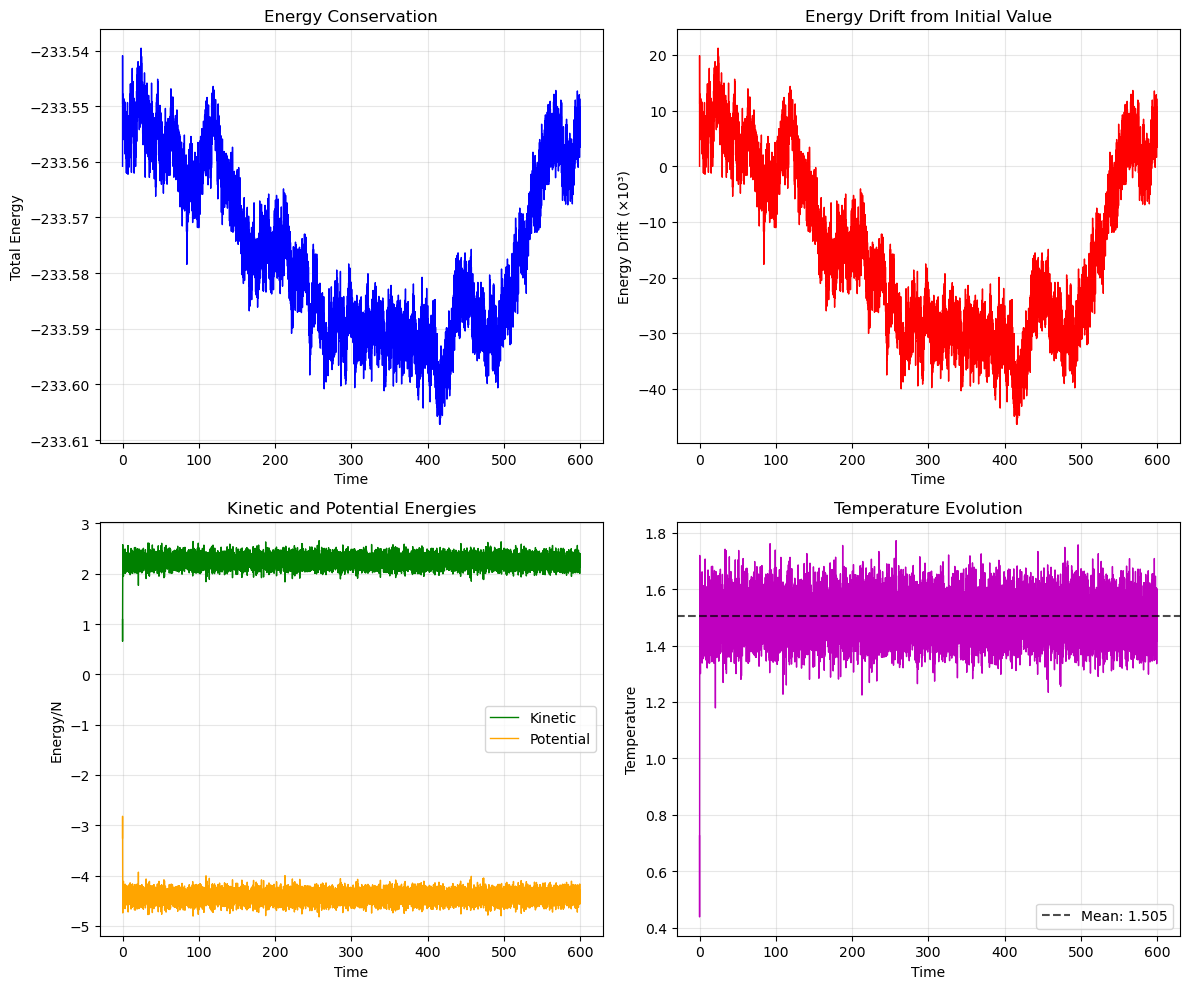

In [6]:
def lennard_jones_force_fast(positions, L, epsilon, sigma, cutoff):
    """Vectorised Lennard-Jones force calculation for better performance."""
    N = len(positions)
    forces = np.zeros_like(positions)
    potential_energy = 0.0
    
    # Shift correction at cutoff
    u_cut = 4.0 * ((1.0/cutoff)**12 - (1.0/cutoff)**6)
    cutoff_sq = cutoff**2
    
    # Calculate all pairwise distances at once
    dr = positions[:, np.newaxis] - positions[np.newaxis, :]  # Shape: (N, N, 3)
    
    # Apply minimum image convention
    dr = dr - L * np.round(dr / L)
    
    # Calculate squared distances
    r_sq = np.sum(dr**2, axis=2)  # Shape: (N, N)
    
    # Create mask for valid pairs (upper triangle, within cutoff, not self)
    mask = np.triu(np.ones((N, N), dtype=bool), k=1) & (r_sq < cutoff_sq) & (r_sq > 0)
    
    # Get indices of valid pairs
    i_indices, j_indices = np.where(mask)
    
    if len(i_indices) > 0:
        # Extract distances and displacement vectors for valid pairs
        r_sq_valid = r_sq[i_indices, j_indices]
        r_valid = np.sqrt(r_sq_valid)
        dr_valid = dr[i_indices, j_indices]  # Shape: (n_pairs, 3)
        
        # Vectorised LJ calculations
        r6_inv = (1.0 / r_valid)**6
        r12_inv = r6_inv**2
        
        # Potential energy
        u_lj = 4.0 * (r12_inv - r6_inv) - u_cut
        potential_energy = np.sum(u_lj)
        
        # Force magnitude
        force_mag = 24.0 * (2 * r12_inv - r6_inv) / r_valid
        
        # Force vectors
        force_vectors = force_mag[:, np.newaxis] * dr_valid / r_valid[:, np.newaxis]
        
        # Accumulate forces (Newton's third law)
        np.add.at(forces, i_indices, force_vectors)
        np.add.at(forces, j_indices, -force_vectors)
    
    return forces, potential_energy

def velocity_verlet_step_fast(positions, velocities, forces, dt, L, mass):
    """Optimised velocity-Verlet step using fast force calculation."""
    
    # Step 1: Update positions
    accelerations = forces / mass
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    
    # Apply periodic boundary conditions
    new_positions = new_positions - L * np.round(new_positions / L)
    
    # Step 2: Calculate forces at new positions
    new_forces, potential_energy = lennard_jones_force_fast(new_positions, L, epsilon, sigma, cutoff)
    
    # Step 3: Update velocities
    new_accelerations = new_forces / mass
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
    
    return new_positions, new_velocities, new_forces, potential_energy

def run_md_simulation(initial_positions, initial_velocities, initial_forces, 
                     dt, n_steps, L, mass, save_frequency=50):
    """Run the main MD simulation loop with optimised force calculation."""
    
    # Initialize arrays
    positions = initial_positions.copy()
    velocities = initial_velocities.copy()
    forces = initial_forces.copy()
    
    # Data storage arrays
    n_save = n_steps // save_frequency + 1
    trajectory = np.zeros((n_save, N_particles, 3))
    kinetic_energies = np.zeros(n_save)
    potential_energies = np.zeros(n_save)
    total_energies = np.zeros(n_save)
    temperatures = np.zeros(n_save)
    times = np.zeros(n_save)
    
    # Calculate initial properties with fast force calculation
    _, potential_energy = lennard_jones_force_fast(positions, L, epsilon, sigma, cutoff)
    kinetic_energy, total_energy, temp = calculate_system_properties(
        positions, velocities, potential_energy, mass, N_particles)
    
    print(f"Starting optimised MD simulation:")
    print(f"Total steps: {n_steps}")
    print(f"Time step: {dt}")
    print(f"Save frequency: every {save_frequency} steps")
    print(f"Initial total energy: {total_energy:.6f}")
    print(f"Initial temperature: {temp:.6f}")
    print()
    
    # Store initial data
    trajectory[0] = positions.copy()
    kinetic_energies[0] = kinetic_energy
    potential_energies[0] = potential_energy
    total_energies[0] = total_energy
    temperatures[0] = temp
    times[0] = 0.0
    
    # Main simulation loop
    save_index = 1
    for step in range(1, n_steps + 1):
        # Perform integration step
        positions, velocities, forces, potential_energy = velocity_verlet_step_fast(
            positions, velocities, forces, dt, L, mass)
        
        # Calculate system properties
        kinetic_energy, total_energy, temp = calculate_system_properties(
            positions, velocities, potential_energy, mass, N_particles)
        
        # Save data at specified frequency
        if step % save_frequency == 0 and save_index < n_save:
            trajectory[save_index] = positions.copy()
            kinetic_energies[save_index] = kinetic_energy
            potential_energies[save_index] = potential_energy
            total_energies[save_index] = total_energy
            temperatures[save_index] = temp
            times[save_index] = step * dt
            save_index += 1
        
        # Progress reporting
        if step % (n_steps // 20) == 0:
            progress = 100 * step / n_steps
            print(f"Progress: {progress:5.1f}% | Step: {step:6d} | "
                  f"Energy: {total_energy:8.4f} | Temp: {temp:6.3f}")
    
    print("Simulation completed!")
    
    return (trajectory[:save_index], times[:save_index], kinetic_energies[:save_index], 
            potential_energies[:save_index], total_energies[:save_index], temperatures[:save_index])

# Test the optimised force calculation speed
import time
print("Testing optimised force calculation speed...")
start_time = time.time()
test_forces, test_pe = lennard_jones_force_fast(positions, L, epsilon, sigma, cutoff)
end_time = time.time()
print(f"Fast force calculation took: {end_time - start_time:.4f} seconds")

# Compare with original (if you want to test)
# start_time = time.time()
# original_forces, original_pe = lennard_jones_force(positions, L, epsilon, sigma, cutoff)
# end_time = time.time()
# print(f"Original force calculation took: {end_time - start_time:.4f} seconds")

# Run the optimised simulation with fewer steps for testing
print("\nRunning optimised simulation...")
trajectory, times, ke_data, pe_data, total_e_data, temp_data = run_md_simulation(
    positions, velocities, forces, dt, n_steps, L, mass, save_frequency=100)

# Calculate energy conservation statistics
initial_energy = total_e_data[0]
energy_drift = total_e_data - initial_energy
max_energy_drift = np.max(np.abs(energy_drift))
rms_energy_drift = np.sqrt(np.mean(energy_drift**2))

print(f"\nSimulation statistics:")
print(f"Initial total energy: {initial_energy:.6f}")
print(f"Final total energy: {total_e_data[-1]:.6f}")
print(f"Maximum energy drift: {max_energy_drift:.2e}")
print(f"RMS energy drift: {rms_energy_drift:.2e}")
print(f"Average temperature: {np.mean(temp_data):.4f} ± {np.std(temp_data):.4f}")

# Plot energy conservation and temperature evolution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Total energy
ax1.plot(times, total_e_data, 'b-', linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Energy')
ax1.set_title('Energy Conservation')
ax1.grid(True, alpha=0.3)

# Energy drift
ax2.plot(times, energy_drift * 1000, 'r-', linewidth=1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy Drift (×10³)')
ax2.set_title('Energy Drift from Initial Value')
ax2.grid(True, alpha=0.3)

# Kinetic and potential energies
ax3.plot(times, ke_data, 'g-', label='Kinetic', linewidth=1)
ax3.plot(times, pe_data, 'orange', label='Potential', linewidth=1)
ax3.set_xlabel('Time')
ax3.set_ylabel('Energy')
ax3.set_title('Kinetic and Potential Energies')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Temperature
ax4.plot(times, temp_data, 'm-', linewidth=1)
ax4.axhline(y=np.mean(temp_data), color='k', linestyle='--', alpha=0.7, 
           label=f'Mean: {np.mean(temp_data):.3f}')
ax4.set_xlabel('Time')
ax4.set_ylabel('Temperature')
ax4.set_title('Temperature Evolution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Run the simulation
trajectory, times, ke_data, pe_data, total_e_data, temp_data = run_md_simulation(
    positions, velocities, forces, dt, n_steps, L, mass, save_frequency=50)

# Calculate energy conservation statistics
initial_energy = total_e_data[0]
energy_drift = total_e_data - initial_energy
max_energy_drift = np.max(np.abs(energy_drift))
rms_energy_drift = np.sqrt(np.mean(energy_drift**2))

print(f"\nSimulation statistics:")
print(f"Initial total energy: {initial_energy:.6f}")
print(f"Final total energy: {total_e_data[-1]:.6f}")
print(f"Maximum energy drift: {max_energy_drift:.2e}")
print(f"RMS energy drift: {rms_energy_drift:.2e}")
print(f"Average temperature: {np.mean(temp_data):.4f} ± {np.std(temp_data):.4f}")

# Plot energy conservation and temperature evolution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Total energy
ax1.plot(times, total_e_data, 'b-', linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Energy')
ax1.set_title('Energy Conservation')
ax1.grid(True, alpha=0.3)

# Energy drift
ax2.plot(times, energy_drift * 1000, 'r-', linewidth=1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy Drift (×10³)')
ax2.set_title('Energy Drift from Initial Value')
ax2.grid(True, alpha=0.3)

# Kinetic and potential energies
ax3.plot(times, ke_data/108, 'g-', label='Kinetic', linewidth=1)
ax3.plot(times, pe_data/108, 'orange', label='Potential', linewidth=1)
ax3.set_xlabel('Time')
ax3.set_ylabel('Energy/N')
ax3.set_title('Kinetic and Potential Energies')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Temperature
ax4.plot(times, temp_data, 'm-', linewidth=1)
ax4.axhline(y=np.mean(temp_data), color='k', linestyle='--', alpha=0.7, 
           label=f'Mean: {np.mean(temp_data):.3f}')
ax4.set_xlabel('Time')
ax4.set_ylabel('Temperature')
ax4.set_title('Temperature Evolution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
def flyvbjerg_petersen_analysis(data, max_block_size=None):
    """
    Implement the Flyvbjerg-Petersen method for error analysis
    
    Parameters:
    data: array of measurements (e.g., potential energy values)
    max_block_size: maximum block size to consider
    
    Returns:
    block_sizes, standard_errors, num_blocks
    """
    
    data = np.array(data)
    n_data = len(data)
    
    # Set maximum block size if not provided
    if max_block_size is None:
        max_block_size = n_data // 4  # Don't go beyond n/4 for meaningful statistics
    
    block_sizes = []
    standard_errors = []
    num_blocks_list = []
    
    # Start with block size 1 and keep doubling
    block_size = 1
    while block_size <= max_block_size:
        # Calculate number of complete blocks
        num_blocks = n_data // block_size
        
        if num_blocks < 2:  # Need at least 2 blocks for variance
            break
            
        # Reshape data into blocks and calculate block averages
        truncated_data = data[:num_blocks * block_size]
        blocks = truncated_data.reshape(num_blocks, block_size)
        block_averages = np.mean(blocks, axis=1)
        
        # Calculate standard error of the block averages
        block_mean = np.mean(block_averages)
        block_variance = np.var(block_averages, ddof=1)  # Sample variance
        standard_error = np.sqrt(block_variance / num_blocks)
        
        block_sizes.append(block_size)
        standard_errors.append(standard_error)
        num_blocks_list.append(num_blocks)
        
        # Double the block size for next iteration
        block_size *= 2
    
    return np.array(block_sizes), np.array(standard_errors), np.array(num_blocks_list)

def plot_flyvbjerg_petersen(block_sizes, standard_errors, num_blocks, quantity_name="Observable"):
    """Plot the Flyvbjerg-Petersen analysis results"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot standard error vs number of blocking operations
    # Number of blocking operations M is log2(block_size)
    M = np.log2(block_sizes).astype(int)
    ax1.plot(M, standard_errors, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of blocking operations (M)')
    ax1.set_ylabel('Standard Error')
    ax1.set_title(f'Flyvbjerg-Petersen Analysis\n{quantity_name}')
    ax1.grid(True, alpha=0.3)
    
    # Add text showing the plateau value
    if len(standard_errors) > 3:
        plateau_error = standard_errors[-1]  # Take last value as plateau estimate
        ax1.axhline(y=plateau_error, color='red', linestyle='--', alpha=0.7)
        ax1.text(0.02, 0.98, f'Plateau: {plateau_error:.6f}', 
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot standard error vs block size
    ax2.loglog(block_sizes, standard_errors, 'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('Block Size')
    ax2.set_ylabel('Standard Error')
    ax2.set_title('Standard Error vs Block Size')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Flyvbjerg-Petersen analysis functions defined successfully!")

Flyvbjerg-Petersen analysis functions defined successfully!


In [ ]:
def analyze_simulation_energies(times, ke_data, pe_data, total_e_data, equilibration_fraction=0.2):
    """
    Perform complete energy analysis with Flyvbjerg-Petersen error estimation
    """
    
    # Remove equilibration period
    n_total = len(times)
    equilibration_steps = int(equilibration_fraction * n_total)
    
    print(f"=== SIMULATION ENERGY ANALYSIS ===")
    print(f"Total data points: {n_total}")
    print(f"Equilibration period: {equilibration_steps} points ({equilibration_fraction*100:.1f}%)")
    print(f"Analysis period: {n_total - equilibration_steps} points")
    print()
    
    # Extract equilibrated data
    equilibrated_ke = ke_data[equilibration_steps:]
    equilibrated_pe = pe_data[equilibration_steps:]
    equilibrated_te = total_e_data[equilibration_steps:]
    
    # Basic statistics
    mean_ke = np.mean(equilibrated_ke)
    mean_pe = np.mean(equilibrated_pe)
    mean_te = np.mean(equilibrated_te)
    
    print("=== BASIC STATISTICS (per particle) ===")
    print(f"Mean kinetic energy: {mean_ke/N_particles:.6f}")
    print(f"Mean potential energy: {mean_pe/N_particles:.6f}")
    print(f"Mean total energy: {mean_te/N_particles:.6f}")
    print()
    
    # Flyvbjerg-Petersen analysis for each quantity
    print("=== FLYVBJERG-PETERSEN ERROR ANALYSIS ===")
    
    # Kinetic Energy Analysis
    print("\n--- KINETIC ENERGY ---")
    ke_per_particle = equilibrated_ke / N_particles
    block_sizes_ke, std_errors_ke, num_blocks_ke = flyvbjerg_petersen_analysis(ke_per_particle)
    
    print("M (blocking ops) | Block Size | Standard Error | Number of Blocks")
    print("-" * 65)
    for i, (bs, se, nb) in enumerate(zip(block_sizes_ke, std_errors_ke, num_blocks_ke)):
        M = int(np.log2(bs))
        print(f"{M:15d} | {bs:10d} | {se:13.6f} | {nb:12d}")
    
    if len(std_errors_ke) >= 3:
        final_uncertainty_ke = std_errors_ke[-1]
        # Convert kinetic energy to temperature (3/2 * kT = KE for 3D)
        # For LJ units: T = (2/3) * KE_per_particle
        temperature = (2.0/3.0) * np.mean(ke_per_particle)
        temp_uncertainty = (2.0/3.0) * final_uncertainty_ke
        
        print(f"\nKINETIC ENERGY RESULTS:")
        print(f"K/N = {np.mean(ke_per_particle):.6f} ± {final_uncertainty_ke:.6f}")
        print(f"Temperature = {temperature:.6f} ± {temp_uncertainty:.6f}")
    
    # Potential Energy Analysis
    print("\n--- POTENTIAL ENERGY ---")
    pe_per_particle = equilibrated_pe / N_particles
    block_sizes_pe, std_errors_pe, num_blocks_pe = flyvbjerg_petersen_analysis(pe_per_particle)
    
    print("M (blocking ops) | Block Size | Standard Error | Number of Blocks")
    print("-" * 65)
    for i, (bs, se, nb) in enumerate(zip(block_sizes_pe, std_errors_pe, num_blocks_pe)):
        M = int(np.log2(bs))
        print(f"{M:15d} | {bs:10d} | {se:13.6f} | {nb:12d}")
    
    if len(std_errors_pe) >= 3:
        final_uncertainty_pe = std_errors_pe[-1]
        print(f"\nPOTENTIAL ENERGY RESULTS:")
        print(f"U/N = {np.mean(pe_per_particle):.6f} ± {final_uncertainty_pe:.6f}")
    
    # Total Energy Analysis
    print("\n--- TOTAL ENERGY ---")
    te_per_particle = equilibrated_te / N_particles
    block_sizes_te, std_errors_te, num_blocks_te = flyvbjerg_petersen_analysis(te_per_particle)
    
    print("M (blocking ops) | Block Size | Standard Error | Number of Blocks")
    print("-" * 65)
    for i, (bs, se, nb) in enumerate(zip(block_sizes_te, std_errors_te, num_blocks_te)):
        M = int(np.log2(bs))
        print(f"{M:15d} | {bs:10d} | {se:13.6f} | {nb:12d}")
    
    if len(std_errors_te) >= 3:
        final_uncertainty_te = std_errors_te[-1]
        print(f"\nTOTAL ENERGY RESULTS:")
        print(f"E/N = {np.mean(te_per_particle):.6f} ± {final_uncertainty_te:.6f}")
        print(f"Target E/N = {target_total_energy_per_particle:.6f}")
        print(f"Difference from target: {(np.mean(te_per_particle) - target_total_energy_per_particle):.6f}")
    
    # Create plots
    if len(std_errors_ke) >= 3:
        plot_flyvbjerg_petersen(block_sizes_ke, std_errors_ke, num_blocks_ke, "Kinetic Energy per Particle")
    
    if len(std_errors_pe) >= 3:
        plot_flyvbjerg_petersen(block_sizes_pe, std_errors_pe, num_blocks_pe, "Potential Energy per Particle")
    
    if len(std_errors_te) >= 3:
        plot_flyvbjerg_petersen(block_sizes_te, std_errors_te, num_blocks_te, "Total Energy per Particle")
    
    # Return final results
    results = {
        'kinetic_energy': (np.mean(ke_per_particle), final_uncertainty_ke if len(std_errors_ke) >= 3 else np.std(ke_per_particle)/np.sqrt(len(ke_per_particle))),
        'potential_energy': (np.mean(pe_per_particle), final_uncertainty_pe if len(std_errors_pe) >= 3 else np.std(pe_per_particle)/np.sqrt(len(pe_per_particle))),
        'total_energy': (np.mean(te_per_particle), final_uncertainty_te if len(std_errors_te) >= 3 else np.std(te_per_particle)/np.sqrt(len(te_per_particle))),
        'temperature': (temperature, temp_uncertainty if len(std_errors_ke) >= 3 else (2.0/3.0)*np.std(ke_per_particle)/np.sqrt(len(ke_per_particle)))
    }
    
    return results

# Perform the complete energy analysis
final_results = analyze_simulation_energies(times, ke_data, pe_data, total_e_data, equilibration_fraction=0.2)

print("\n" + "="*80)
print("FINAL SIMULATION RESULTS")
print("="*80)
print(f"Kinetic Energy per particle:  {final_results['kinetic_energy'][0]:.6f} ± {final_results['kinetic_energy'][1]:.6f}")
print(f"Potential Energy per particle: {final_results['potential_energy'][0]:.6f} ± {final_results['potential_energy'][1]:.6f}")
print(f"Total Energy per particle:     {final_results['total_energy'][0]:.6f} ± {final_results['total_energy'][1]:.6f}")
print(f"Temperature:                   {final_results['temperature'][0]:.6f} ± {final_results['temperature'][1]:.6f}")
print(f"Target Total Energy:           {target_total_energy_per_particle:.6f}")
print("="*80)

# Run the simulation
trajectory, times, ke_data, pe_data, total_e_data, temp_data = run_md_simulation(
    positions, velocities, forces, dt, n_steps, L, mass, save_frequency=50)

# Calculate energy conservation statistics
initial_energy = total_e_data[0]
energy_drift = total_e_data - initial_energy
max_energy_drift = np.max(np.abs(energy_drift))
rms_energy_drift = np.sqrt(np.mean(energy_drift**2))

print(f"\nSimulation statistics:")
print(f"Initial total energy: {initial_energy:.6f}")
print(f"Final total energy: {total_e_data[-1]:.6f}")
print(f"Maximum energy drift: {max_energy_drift:.2e}")
print(f"RMS energy drift: {rms_energy_drift:.2e}")
print(f"Average temperature: {np.mean(temp_data):.4f} ± {np.std(temp_data):.4f}")

# Plot energy conservation and temperature evolution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Total energy
ax1.plot(times, total_e_data, 'b-', linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Energy')
ax1.set_title('Energy Conservation')
ax1.grid(True, alpha=0.3)

# Energy drift
ax2.plot(times, energy_drift * 1000, 'r-', linewidth=1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy Drift (×10³)')
ax2.set_title('Energy Drift from Initial Value')
ax2.grid(True, alpha=0.3)

# Kinetic and potential energies
ax3.plot(times, ke_data, 'g-', label='Kinetic', linewidth=1)
ax3.plot(times, pe_data, 'orange', label='Potential', linewidth=1)
ax3.set_xlabel('Time')
ax3.set_ylabel('Energy')
ax3.set_title('Kinetic and Potential Energies')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Temperature
ax4.plot(times, temp_data, 'm-', linewidth=1)
ax4.axhline(y=np.mean(temp_data), color='k', linestyle='--', alpha=0.7, 
           label=f'Mean: {np.mean(temp_data):.3f}')
ax4.set_xlabel('Time')
ax4.set_ylabel('Temperature')
ax4.set_title('Temperature Evolution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'times' is not defined